# Key: Cathode = 0, Gate = 1, Tritium = 2

# Imports

In [16]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import random
import pickle
import pyarrow as pa

In [17]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sn

In [18]:
import pandas as pd
import awkward as ak
import pyarrow.parquet as pq

import hist
from hist import Hist, axis

plt.rcParams['figure.figsize'] = [10, 8]
font = {'weight' : 'normal','size'   : 22}
plt.rc('font', **font)
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast
import xgboost as xgb

In [19]:
# Load data from pickle files and convert to strings
# data_path = 'LZ Datasets/padded_waveforms.parquet'

files = [
    '/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/SR1S2OAnalysis_Signal_SR3.pkl',
    '/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/SR1S2OAnalysis_Gate_SR3.pkl',
    '/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/SR1S2OAnalysis_Cathode_SR3.pkl',
]

tritium = pd.read_pickle('/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/SR1S2OAnalysis_Signal_SR3.pkl')
gate = pd.read_pickle('/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/SR1S2OAnalysis_Gate_SR3.pkl')
cathode = pd.read_pickle('/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/SR1S2OAnalysis_Cathode_SR3.pkl')

# print(df)
print(tritium.info())
print(gate.info())
print(cathode.info())

# Randomly sample 3500 rows from each DataFrame
tritium_sample = tritium.sample(n=3500, random_state=42)
gate_sample = gate.sample(n=3500, random_state=42)
cathode_sample = cathode.sample(n=3500, random_state=42)

# Add label columns
tritium_sample['label'] = 2
gate_sample['label'] = 1
cathode_sample['label'] = 0

# Concatenate all samples into one large DataFrame
df = pd.concat([tritium_sample, gate_sample, cathode_sample], ignore_index=True)
df['Volume'] = df['Volume'].astype(str) # Volume was initially a category dtype which Arrow converts to dictionary-encoded field whereby key is integer code name and definition is corresponding
# qualitative category. 

print(df.dtypes)

# Check the result
print(df.shape)
print(df.head())

# Conversion of combined df into awkward array for data processing, Starting with Awkward 2, the function ak.from_pandas no longer exists. 
# Instead, one common way to get a Pandas DataFrame into an Awkward Array is to go through PyArrow.
table = pa.Table.from_pandas(df)
arr = ak.from_arrow(table)

print(arr.fields) #analogous to df.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339138 entries, 18 to 2572084
Data columns (total 62 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   CX_HSX                 339138 non-null  int32   
 1   CX_MUONVETO            339138 non-null  int32   
 2   CX_ETV                 339138 non-null  int32   
 3   CX_S1RATE              339138 non-null  int32   
 4   CX_SUSTPHRATE          339138 non-null  int32   
 5   CX_S2LB                339138 non-null  int32   
 6   CX_S2UB                339138 non-null  int32   
 7   CX_FV                  339138 non-null  bool    
 8   CX_FCRES               339138 non-null  int32   
 9   CX_PROMINENTS2         339138 non-null  int32   
 10  CX_NARROWS2            339138 non-null  bool    
 11  CX_S2EARLYPEAK         339138 non-null  bool    
 12  CX_XYQUAL              339138 non-null  int32   
 13  CX_S2TBA               339138 non-null  bool    
 14  CX_BUFF           

# Created the Boosted Decision Tree (BDT) Model


In [20]:
# 1. Define the AFT column suffixes in ascending order
aft_suffixes = [1, 5, 10, 25, 50, 75, 90, 95, 99]

# 2. Create difference columns
#    For each adjacent pair (e.g., 1->5, 5->10, 10->25, etc.),
#    subtract the earlier from the later.
diff_col_names = []
for i in range(len(aft_suffixes) - 1):
    aft1 = aft_suffixes[i]
    aft2 = aft_suffixes[i+1]
    # print(aft1, aft2)
    
    # Name for the new difference column, e.g. "diffAFT1_5", "diffAFT5_10", ...
    col_name = f'diffAFT{aft1}_{aft2}'
    # print(col_name)
    
    # Compute the difference
    df[col_name] = df[f'scatterS2AFT{aft2}'] - df[f'scatterS2AFT{aft1}']
    
    diff_col_names.append(col_name)

# 3. Define the additional columns you want to include directly
other_cols = ['scatterS2fwhm', 'peakAmp', 'scatterS2TBA', 'scatterS2XYChi2', 'label']

# 4. Create the final DataFrame for BDT input
bdt_input = df[diff_col_names + other_cols]

# bdt_input now contains only the difference columns and the listed columns
print(bdt_input.head())


   diffAFT1_5  diffAFT5_10  diffAFT10_25  diffAFT25_50  diffAFT50_75  \
0         540          460          1050           910          1050   
1         440          250           540           700           870   
2         480          310           610           740           770   
3         350          240           310           450           440   
4        1030          930          1390           780           660   

   diffAFT75_90  diffAFT90_95  diffAFT95_99  scatterS2fwhm   peakAmp  \
0          1190           440          1150           2230  0.735323   
1          1010           650          1180           2310  1.656896   
2           660           450           990           2790  1.525433   
3           320           150           230           1570  1.539676   
4           500           330          1490           1580  0.816201   

   scatterS2TBA  scatterS2XYChi2  label  
0      0.337375         1.453247      2  
1      0.396880         1.573231      2  
2      0

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1. Separate features and labels
X = bdt_input.drop(columns=["label"])
y = bdt_input["label"]

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,   # 25% for testing
    random_state=42,
    stratify=y
)

# 3. Convert to xgboost's DMatrix format (recommended for efficiency)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 4. Define training parameters
#    We'll do a simple parameter set; will tune later.
params = {
    "objective": "multi:softmax",  # multi-class classification
    "num_class": 3,               # we have classes 0, 1, 2
    "eval_metric": "mlogloss",    # or "merror", "mlogloss" etc.
    "eta": 0.1,                   # learning rate
    "max_depth": 3,               # depth of each tree
    "seed": 42
}

# 5. Train the XGBoost model
evals_result = {}  # store evaluation results
evallist = [(dtrain, "train"), (dtest, "eval")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,   # number of boosting rounds
    evals=evallist,
    evals_result=evals_result,
    verbose_eval=False     # set to True if you want iterative feedback
)

# 6. Make predictions
y_pred = bst.predict(dtest)  # for "multi:softmax", returns class labels directly

# 7. Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))



Confusion Matrix:
[[820   1  54]
 [ 17 746 112]
 [207  46 622]]

Classification Report:
              precision    recall  f1-score   support

           0      0.785     0.937     0.855       875
           1      0.941     0.853     0.894       875
           2      0.789     0.711     0.748       875

    accuracy                          0.834      2625
   macro avg      0.839     0.834     0.832      2625
weighted avg      0.839     0.834     0.832      2625



## BDT Hyperparameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris

# Define the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, objective="multi:softmax", num_class=3, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 6],
}

# Grid search
grid = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='f1_macro', verbose=1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)



AttributeError: 'super' object has no attribute '__sklearn_tags__'

# Creating the ROC Curves

In [ ]:
# Tritium vs Gate (Binary labels: Tritium as 1, Gate as 0; ignore Cathode instances)
mask_tritium_gate = (y_test == 2) | (y_test == 1)  # Only consider tritium and gate instances
y_test_tritium_gate = np.where(y_test[mask_tritium_gate] == 2, 1, 0)  # Tritium = 1, Gate = 0
fpr_gate, tpr_gate, _ = roc_curve(y_test_tritium_gate, y_pred_proba[mask_tritium_gate, 2])
roc_auc_gate = auc(fpr_gate, tpr_gate)

# Tritium vs Cathode (Binary labels: Tritium as 1, Cathode as 0; ignore Gate instances)
mask_tritium_cathode = (y_test == 2) | (y_test == 0)  # Only consider tritium and cathode instances
y_test_tritium_cathode = np.where(y_test[mask_tritium_cathode] == 2, 1, 0)  # Tritium = 1, Cathode = 0
fpr_cathode, tpr_cathode, _ = roc_curve(y_test_tritium_cathode, y_pred_proba[mask_tritium_cathode, 2])
# print(_) these are the array of thresholds used by the roc algorithm
roc_auc_cathode = auc(fpr_cathode, tpr_cathode)

# Step 3: Plot ROC curves with verification of each set
plt.figure(figsize=(12, 8))

# Plot for Tritium vs Gate
plt.plot(fpr_gate, tpr_gate, label=f'Tritium vs Gate (AUC = {roc_auc_gate:.2f})')
plt.xlabel('Gate Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Gate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot for Tritium vs Cathode
plt.figure(figsize=(12, 8))
plt.plot(fpr_cathode, tpr_cathode, label=f'Tritium vs Cathode (AUC = {roc_auc_cathode:.2f})')
plt.xlabel('Cathode Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Cathode')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


NameError: name 'y_test' is not defined

[ 48.75882245 100.02433894 151.28985544 202.55537193 253.82088842
 305.08640491]
y_test_np shape: (1946,)
area_test_np shape: (1946,)


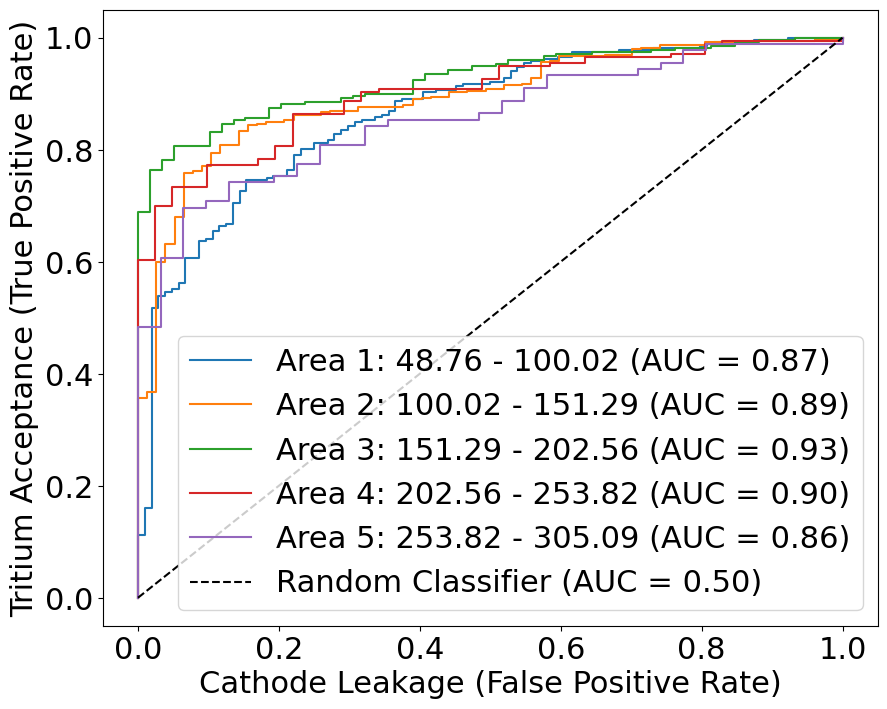

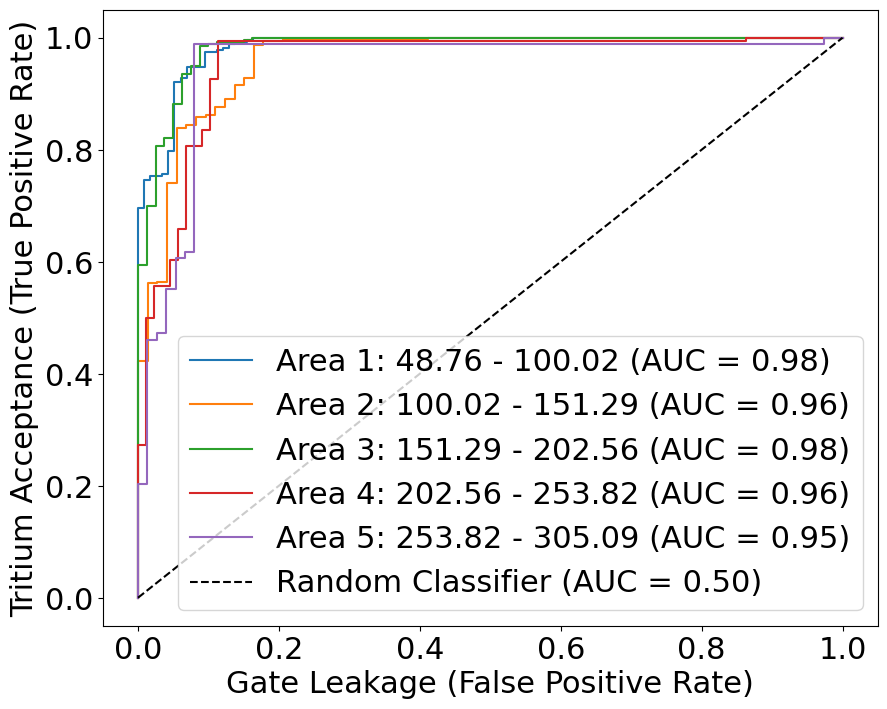

: 

: 

: 

: 

In [ ]:
# Define function to split data into 5 regions based on normalized area for the test set
def get_area_intervals(normalized_area, num_intervals=5):
    min_area = np.min(normalized_area)
    max_area = np.max(normalized_area)
    intervals = np.linspace(min_area, max_area, num_intervals + 1)
    return intervals

# Calculate intervals for splitting area into 5 regions
area_intervals = get_area_intervals(area_test)
print(area_intervals)

# Convert y_test and area_test to NumPy arrays for easier indexing
y_test_np = ak.to_numpy(y_test)
area_test_np = ak.to_numpy(area_test)

# Check conversion
print("y_test_np shape:", y_test_np.shape)
print("area_test_np shape:", area_test_np.shape)

def plot_roc_for_intervals(event_type, y_test, y_pred_proba, label, area_intervals):
    plt.figure(figsize=(10, 8))
    for i in range(len(area_intervals) - 1):
        # Define range for the current interval
        lower, upper = area_intervals[i], area_intervals[i + 1]
        
        # Mask to select data within the current area range and specific event type
        mask = (area_test_np >= lower) & (area_test_np < upper) & ((y_test_np == event_type) | (y_test_np == 2))
        # print(f' this is {y_test_np[mask]}')
        
        # Check if mask correctly applies to y_test
        if np.any(mask):  # Ensure mask is not empty. np.any() returns a boolean value iff any element within 'mask' is true
            y_test_interval = np.where(y_test_np[mask] == 2, 1, 0)  # Tritium = 1, event_type = 0
            
            # Compute ROC for this interval
            fpr, tpr, _ = roc_curve(y_test_interval, y_pred_proba[mask, 2])
            roc_auc = auc(fpr, tpr)
            
            # Plot the ROC curve for this interval
            plt.plot(fpr, tpr, label=f'Area {i+1}: {lower:.2f} - {upper:.2f} (AUC = {roc_auc:.2f})')
    
    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
    
    # Add labels and title
    plt.xlabel(f'{label} Leakage (False Positive Rate)')
    plt.ylabel('Tritium Acceptance (True Positive Rate)')
    # plt.title(f'ROC Curves for Tritium vs {label} across Area Regions')
    plt.legend(loc='lower right')
    plt.show()

# Step 4: Plot ROC curves for Tritium vs Cathode
plot_roc_for_intervals(event_type=0, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Cathode', area_intervals=area_intervals)

# Step 5: Plot ROC curves for Tritium vs Gate
plot_roc_for_intervals(event_type=1, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Gate', area_intervals=area_intervals)


## Figure 7 (LUX-LOWMASS) Production

The probability threshold corresponding to 80% of the tritium data lying after that line is 0.562


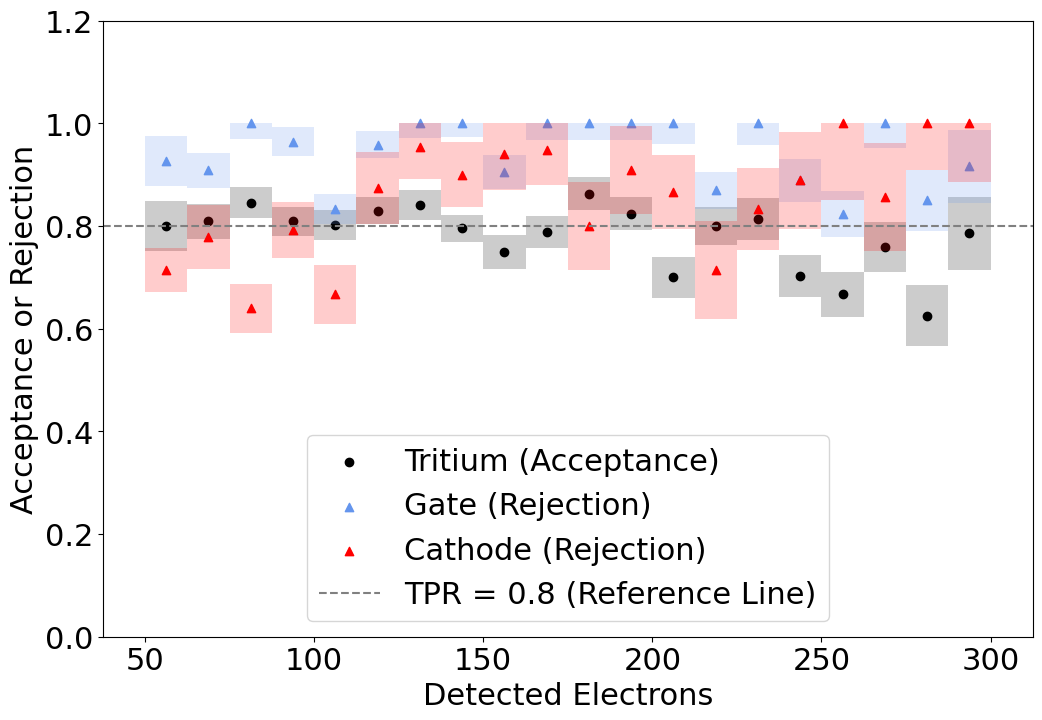

: 

: 

: 

: 

In [ ]:
# Increase the number of bins for more points in the scatter plot
num_bins = 20 # Adjust this number to make the bins smaller and create more points

print(f"The probability threshold corresponding to 80% of the tritium data lying after that line is {threshold:.3f}")

bin_edges = np.linspace(50, 300, num_bins + 1)  # Uniform bins between 50 and 300

# Placeholder for storing acceptance values
# Placeholder for storing acceptance and rejection values
tritium_acceptance = []
gate_rejection = []
cathode_rejection = []
tritium_error = []
gate_error = []
cathode_error = []

# Function to calculate bin widths
def calculate_bin_widths(bin_edges):
    return bin_edges[1] - bin_edges[0]

# Loop through each bin
for i in range(len(bin_edges) - 1):
    # Define bin range
    lower, upper = bin_edges[i], bin_edges[i + 1]
    bin_center = (lower + upper) / 2
    bin_width = calculate_bin_widths(bin_edges)  # Dynamic bin width

    # Filter data points within the current bin
    mask = (area_test_np >= lower) & (area_test_np < upper)
    
    if np.any(mask):  # Skip bins with no data points
        # Extract data points for Tritium, Gate, and Cathode
        tritium_mask = mask & (y_test_np == 2)
        gate_mask = mask & (y_test_np == 1)
        cathode_mask = mask & (y_test_np == 0)

        # Calculate acceptance for Tritium
        tritium_proba = y_pred_proba[tritium_mask, 2]
        if len(tritium_proba) > 0:  # Ensure there are Tritium samples
           # dynamic_threshold = np.percentile(tritium_proba, 20)  # 20th percentile threshold for this bin
            accepted_tritium = np.sum(tritium_proba >= threshold)  # Count Tritium points above threshold
            total_tritium = len(tritium_proba)
            tritium_acceptance.append((bin_center, accepted_tritium / total_tritium))  # Normalize by true Tritium count
            error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            tritium_error.append(min(error,1))
        else:
            tritium_acceptance.append((bin_center, 0))  # No Tritium events in this bin

        # Calculate rejection rates for Gate and Cathode
        gate_proba = y_pred_proba[gate_mask, 2]
        if len(gate_proba) > 0:
            rejected_gate = np.sum(gate_proba <= threshold)  # true negatives (in terms of actual signal events) for Gate
            total_gate = len(gate_proba)
            gate_rejection.append((bin_center, (rejected_gate / total_gate)))  # Normalise by true Gate count
            error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            gate_error.append(min(error,1))
        else:
            gate_rejection.append((bin_center, 0))

        cathode_proba = y_pred_proba[cathode_mask, 2]
        if len(cathode_proba) > 0:
            rejected_cathode = np.sum(cathode_proba <= threshold)  # true negatives (in terms of actual signal events) for Cathode
            total_cathode = len(cathode_proba)
            cathode_rejection.append((bin_center, (rejected_cathode) / total_cathode))  # Normalise by true Cathode count
            error = (np.sqrt(rejected_cathode) / total_cathode) * 0.3
            cathode_error.append(min(error,1))
        else:
            cathode_rejection.append((bin_center, 0))

# Convert collected points into arrays for plotting
tritium_x, tritium_y = zip(*tritium_acceptance)
gate_x, gate_y = zip(*gate_rejection)
cathode_x, cathode_y = zip(*cathode_rejection)

# Plot the results
plt.figure(figsize=(12, 8))

# Plot Tritium acceptance points with error bars
for x, y, error in zip(tritium_x, tritium_y, tritium_error):
    plt.scatter(x, y, color='black', label='Tritium (Acceptance)' if x == tritium_x[0] else "")
    plt.fill_betweenx([y - error, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='black', alpha=0.2, linewidth=0)

# Plot Gate rejection points with error bars
for x, y, error in zip(gate_x, gate_y, gate_error):
    plt.scatter(x, y, color='cornflowerblue', marker='^', label='Gate (Rejection)' if x == gate_x[0] else "")
    plt.fill_betweenx([y - error, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='cornflowerblue', alpha=0.2, linewidth=0)

# Plot Cathode rejection points with error bars
for x, y, error in zip(cathode_x, cathode_y, cathode_error):
    plt.scatter(x, y, color='red', marker='^', label='Cathode (Rejection)' if x == cathode_x[0] else "")
    plt.fill_betweenx([y - error,1, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='red', alpha=0.2, linewidth=0)


plt.axhline(y=0.8, color='gray', linestyle='--', label='TPR = 0.8 (Reference Line)')
plt.ylim(0, 1.2)

plt.xlabel("Detected Electrons")
plt.ylabel("Acceptance or Rejection")
plt.legend(loc='lower center')
plt.show()


